## ref : https://www.kaggle.com/aiswaryaramachandran/eda-baseline-model-0-40-rmse

In [1]:
# %%time
# import sys
# !cp ../input/rapids/rapids.0.11.0 /opt/conda/envs/rapids.tar.gz
# !cd /opt/conda/envs/ && tar -xzvf rapids.tar.gz
# sys.path = ["/opt/conda/envs/rapids/lib"] + ["/opt/conda/envs/rapids/lib/python3.6"] + ["/opt/conda/envs/rapids/lib/python3.6/site-packages"] + sys.path
# !cp /opt/conda/envs/rapids/lib/libxgboost.so /opt/conda/lib/

# import cudf

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from math import sin, cos, sqrt, atan2, radians
pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', '{:.5f}'.format)

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium import plugins
plt.style.use('fivethirtyeight')

import datetime as dt
from datetime import datetime
from haversine import haversine_vector

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/rapids/rapids.0.12.0
/kaggle/input/rapids/rapids.0.13.0
/kaggle/input/rapids/rapids.0.11.0
/kaggle/input/nyc-taxi-trip-duration/test.zip
/kaggle/input/nyc-taxi-trip-duration/sample_submission.zip
/kaggle/input/nyc-taxi-trip-duration/train.zip


## Load & Preprocess data

In [3]:
train = pd.read_csv('../input/nyc-taxi-trip-duration/train.zip')
test = pd.read_csv('../input/nyc-taxi-trip-duration/test.zip')

print('train.shape :', train.shape)
print('test.shape :', test.shape)
train.head(2)

train.shape : (1458644, 11)
test.shape : (625134, 9)


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.98215,40.76794,-73.96463,40.76560,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.98042,40.73856,-73.99948,40.73115,N,663


#### 1) Convert datatype

In [4]:
train.pickup_datetime = pd.to_datetime(train.pickup_datetime, format='%Y-%m-%d %H:%M:%S')
train.dropoff_datetime = pd.to_datetime(train.dropoff_datetime, format='%Y-%m-%d %H:%M:%S')

train.head(2)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.98215,40.76794,-73.96463,40.76560,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.98042,40.73856,-73.99948,40.73115,N,663


#### 2) Check missing values

In [5]:
print(f'Total sum of missing values : {train.isna().sum().sum()}')
train.isna().sum()

Total sum of missing values : 0


id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

#### 3) Check time period of dataset

In [6]:
print('>>> Min pickup time :', train.pickup_datetime.min())
print('>>> Max pickup time :', train.pickup_datetime.max())
print('>>> Time peroid of train dataset :', train.pickup_datetime.max() - train.pickup_datetime.min())

>>> Min pickup time : 2016-01-01 00:00:17
>>> Max pickup time : 2016-06-30 23:59:39
>>> Time peroid of train dataset : 181 days 23:59:22


#### 4) Add new feature - date, day, hour, day_of_week

In [7]:
wday_list = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

train['pickup_date'] = train.pickup_datetime.dt.date
train['pickup_day'] = train.pickup_datetime.dt.day
train['pickup_hour'] = train.pickup_datetime.dt.hour
train['pickup_day_of_week'] = train.pickup_datetime.dt.dayofweek.map(lambda x: wday_list[x])

train['dropoff_date'] = train.dropoff_datetime.dt.date
train['dropoff_day'] = train.dropoff_datetime.dt.day
train['dropoff_hour'] = train.dropoff_datetime.dt.hour
train['dropoff_day_of_week'] = train.dropoff_datetime.dt.dayofweek.map(lambda x: wday_list[x])

train.head(2)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,pickup_day,pickup_hour,pickup_day_of_week,dropoff_date,dropoff_day,dropoff_hour,dropoff_day_of_week
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.98215,40.76794,-73.96463,40.76560,N,455,2016-03-14,14,17,Monday,2016-03-14,14,17,Monday
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.98042,40.73856,-73.99948,40.73115,N,663,2016-06-12,12,0,Sunday,2016-06-12,12,0,Sunday


#### 5) Add new feature - Round lat, lng to 3 decimal places

In [8]:
train['pickup_latitude_round3'] = train.pickup_latitude.round(3)
train['pickup_longitude_round3'] = train.pickup_longitude.round(3)

train['dropoff_latitude_round3'] = train.dropoff_latitude.round(3)
train['dropoff_longitude_round3'] = train.dropoff_longitude.round(3)

train.head(2)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,pickup_hour,pickup_day_of_week,dropoff_date,dropoff_day,dropoff_hour,dropoff_day_of_week,pickup_latitude_round3,pickup_longitude_round3,dropoff_latitude_round3,dropoff_longitude_round3
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.98215,40.76794,-73.96463,40.76560,N,...,17,Monday,2016-03-14,14,17,Monday,40.76800,-73.98200,40.76600,-73.96500
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.98042,40.73856,-73.99948,40.73115,N,...,0,Sunday,2016-06-12,12,0,Sunday,40.73900,-73.98000,40.73100,-73.99900


#### 6) Add new feature - trip_distance(using Haversine Distance),  trip_duration_in_hour

In [9]:
train['trip_distance'] = haversine_vector(train[['pickup_latitude', 'pickup_longitude']].to_numpy(),
                                          train[['dropoff_latitude', 'dropoff_longitude']].to_numpy())
train['trip_duration_in_hour'] = train.trip_duration/3600

train.head(2)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,dropoff_date,dropoff_day,dropoff_hour,dropoff_day_of_week,pickup_latitude_round3,pickup_longitude_round3,dropoff_latitude_round3,dropoff_longitude_round3,trip_distance,trip_duration_in_hour
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.98215,40.76794,-73.96463,40.76560,N,...,2016-03-14,14,17,Monday,40.76800,-73.98200,40.76600,-73.96500,1.49852,0.12639
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.98042,40.73856,-73.99948,40.73115,N,...,2016-06-12,12,0,Sunday,40.73900,-73.98000,40.73100,-73.99900,1.80551,0.18417


## Exploratory Data Analysis(EDA)

#### 1) Trip Duration

>>> Basic Statistics of trip_duration_in_hour
median	 0.18389
count   1458644.00000
mean          0.26653
std           1.45484
min           0.00028
25%           0.11028
50%           0.18389
75%           0.29861
max         979.52278
Name: trip_duration_in_hour, dtype: float64


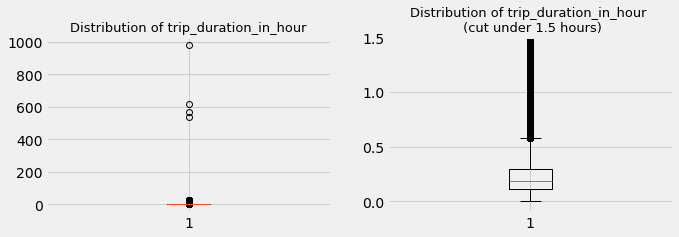

In [10]:
print('>>> Basic Statistics of trip_duration_in_hour')
print(f'median\t {train.trip_duration_in_hour.median():.5f}')
print(train.trip_duration_in_hour.describe())

fig, ax = plt.subplots(1, 2, figsize=(10, 3))

ax[0].boxplot(train.trip_duration_in_hour)
ax[0].set_title('Distribution of trip_duration_in_hour', size=13)

ax[1].boxplot(train.trip_duration_in_hour)
ax[1].set_title('Distribution of trip_duration_in_hour \n (cut under 1.5 hours)', size=13)
ax[1].set_ylim(-0.1, 1.5)
plt.show()

In [11]:
trip_duration_outlier = train[train.trip_duration_in_hour > 24]
trip_duration_outlier

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,dropoff_date,dropoff_day,dropoff_hour,dropoff_day_of_week,pickup_latitude_round3,pickup_longitude_round3,dropoff_latitude_round3,dropoff_longitude_round3,trip_distance,trip_duration_in_hour
355003,id1864733,1,2016-01-05 00:19:42,2016-01-27 11:08:38,1,-73.78965,40.64356,-73.95681,40.77309,N,...,2016-01-27,27,11,Wednesday,40.64400,-73.79000,40.77300,-73.95700,20.14869,538.81556
680594,id0369307,1,2016-02-13 22:38:00,2016-03-08 15:57:38,2,-73.92168,40.73525,-73.98475,40.75998,N,...,2016-03-08,8,15,Tuesday,40.73500,-73.92200,40.76000,-73.98500,5.98250,569.32722
924150,id1325766,1,2016-01-05 06:14:15,2016-01-31 01:01:07,1,-73.98379,40.74232,-73.98549,40.72768,N,...,2016-01-31,31,1,Sunday,40.74200,-73.98400,40.72800,-73.98500,1.63513,618.78111
978383,id0053347,1,2016-02-13 22:46:52,2016-03-25 18:18:14,1,-73.78391,40.64863,-73.97827,40.75020,N,...,2016-03-25,25,18,Friday,40.64900,-73.78400,40.75000,-73.97800,19.90069,979.52278


- There are 4 records whose trip duration is greater than 24 hours.
- The trip distance of the 4 records are not that long. These are outliers.
- We will not remove the outliers from the analysis, because they might be a part of test dataset as well.

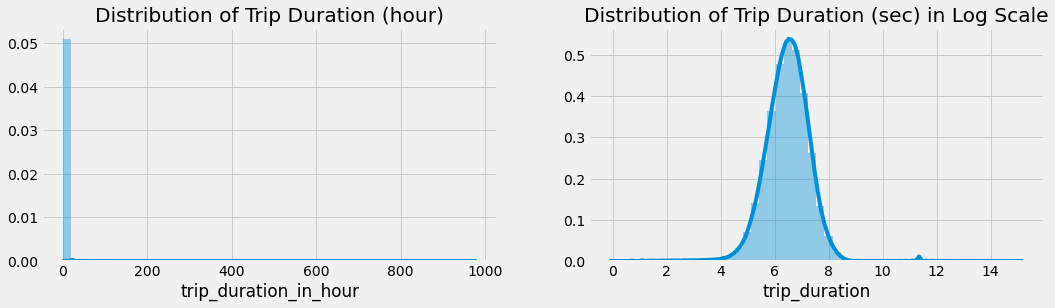

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(16, 4))

sns.distplot(train.trip_duration_in_hour, ax=ax[0]).\
    set_title('Distribution of Trip Duration (hour)')

sns.distplot(np.log(train.trip_duration), ax=ax[1]).\
    set_title('Distribution of Trip Duration (sec) in Log Scale')

plt.show()

- Trip duration is highly skewed, so we need log transformation which makes the variable a normal distribution.
- The durations of most trips are between 54(exp(4)) sec and 2981(exp(8) sec. Therefore, most trips are within one hour.
- There are trip durations less than a minute and trip durations over 100 hours. Trips over 100 hours are especially weird since the taxi rides are within New York.

#### 2) Heatmap of common locations from where pickup and dropoff occurs

In [13]:
pickup_count = train.groupby(['pickup_latitude_round3', 'pickup_longitude_round3'])['id'].count().reset_index().rename(columns={'id':'num_trips'})
dropoff_count = train.groupby(['dropoff_latitude_round3', 'dropoff_longitude_round3'])['id'].count().reset_index().rename(columns={'id':'num_trips'})

pickup_count.head(2)

,pickup_latitude_round3,pickup_longitude_round3,num_trips
0,34.36000,-65.84800,1
1,34.71200,-75.35400,1


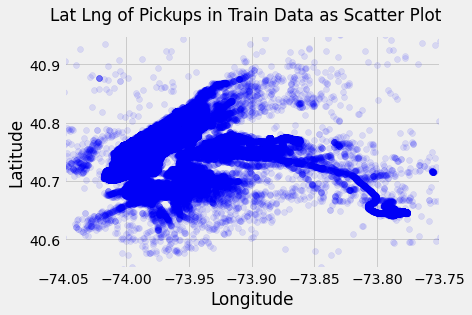

In [14]:
# folium heatmap
pickup_map = folium.Map(location=[40.730610, -73.935242], zoom_start=10,
                        width='80%', height='80%')
heatmap_wide = folium.plugins.HeatMap(pickup_count, min_opacity=0.2,
                                 max_zoom=1, radius=5, blur=15)
pickup_map.add_child(heatmap_wide)
display(pickup_map)


# matplotlib scatterplot
lng_border = (-74.05, -73.75)
lat_border = (40.55, 40.95)

fig, ax = plt.subplots(ncols=1)
ax.scatter(train.pickup_longitude, train.pickup_latitude,
           color='blue', label='train', alpha=0.1)
plt.xlim(lng_border)
plt.ylim(lat_border)

fig.suptitle('Lat Lng of Pickups in Train Data as Scatter Plot')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()

- This graph clearly shows heavy density of pickups near JFK

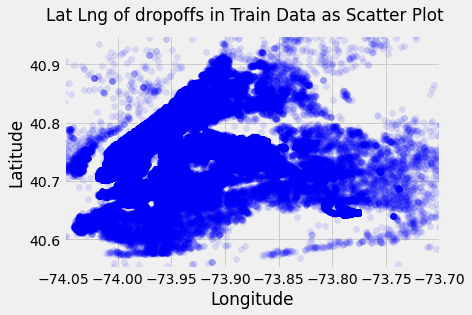

In [15]:
# folium heatmap
dropoff_map = folium.Map(location=[40.730610, -73.935242], zoom_start=10,
                        width='80%', height='80%')
heatmap_wide = folium.plugins.HeatMap(dropoff_count, min_opacity=0.2,
                                 max_zoom=1, radius=5, blur=15)
dropoff_map.add_child(heatmap_wide)
display(dropoff_map)


# matplotlib scatterplot
lng_border = (-74.05, -73.70)
lat_border = (40.55, 40.95)

fig, ax = plt.subplots(ncols=1)
ax.scatter(train.dropoff_longitude, train.dropoff_latitude,
           color='blue', label='train', alpha=0.1)
plt.xlim(lng_border)
plt.ylim(lat_border)

fig.suptitle('Lat Lng of dropoffs in Train Data as Scatter Plot')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()

- The heatmap of dropoffs is similar to that of pickups

#### 3) Heatmap of trip duration, when pickup originates from a point

In [16]:
pickup_mean = train.groupby(['pickup_latitude_round3', 'pickup_longitude_round3'])['trip_duration'].mean().reset_index().rename(columns={'trip_duration':'avg_trip_duration'})
pickup_mean.head(2)

,pickup_latitude_round3,pickup_longitude_round3,avg_trip_duration
0,34.36000,-65.84800,961.00000
1,34.71200,-75.35400,875.00000


In [17]:
pickup_map = folium.Map(location=[40.730610, -73.935242],
                        width='80%', height='80%', zoom_start=10)
heatmap_wide = folium.plugins.HeatMap(pickup_mean, min_opacity=0.2,
                                      max_zoom=1, radius=7, blur=15)
pickup_map.add_child(heatmap_wide)

pickup_map

- When trip originates from JFK, The average trip duration is higher.
- We can see that after the Manhattan, the pickups from JFK tend to have higher trip duration.

#### 4) Distribution of pickup & dropoff by Hours

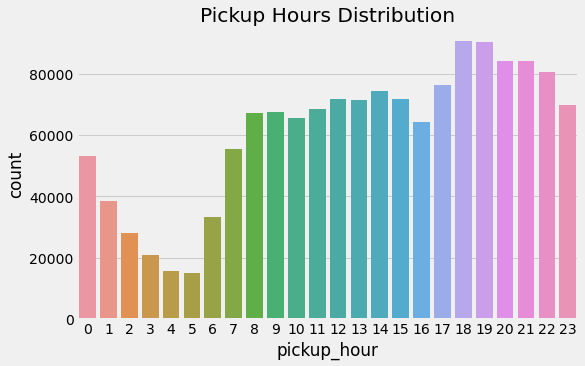

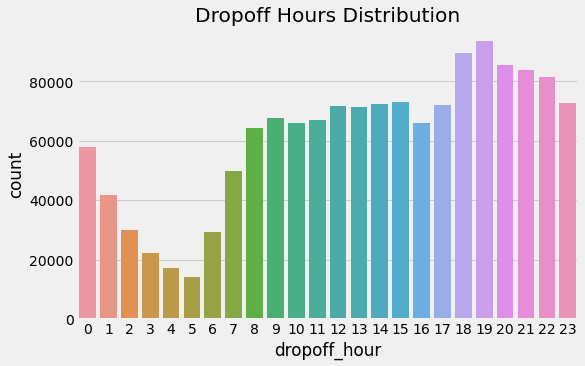

In [18]:
plt.figure(figsize=(8, 5))
sns.countplot(train.pickup_hour).set_title('Pickup Hours Distribution')
plt.show()

plt.figure(figsize=(8, 5))
sns.countplot(train.dropoff_hour).set_title('Dropoff Hours Distribution')
plt.show()

- The pickups are much lower in the early mornings(betweeen 2-6). The pickups are highest in the evenings(between 18-21).
- Distribution of dropoff hour is very similar to that of pickup hour

#### 5) Pickups over the entire time period

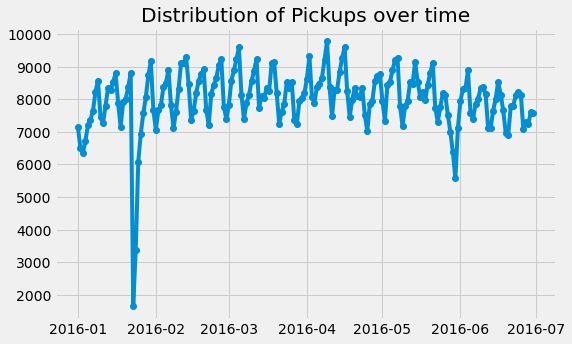

In [19]:
plt.figure(figsize=(8, 5))
plt.plot(train.groupby('pickup_date')['id'].count(), 'o-')
plt.title('Distribution of Pickups over time')
plt.show()

- There is a large drop in the mid-end of January 2016
- There is also a small drop in the end of June 2016

#### 6) Distribution of Trip Distance

count   1458644.00000
mean          3.44087
std           4.29654
min           0.00000
25%           1.23184
50%           2.09372
75%           3.87534
max        1240.91039
Name: trip_distance, dtype: float64

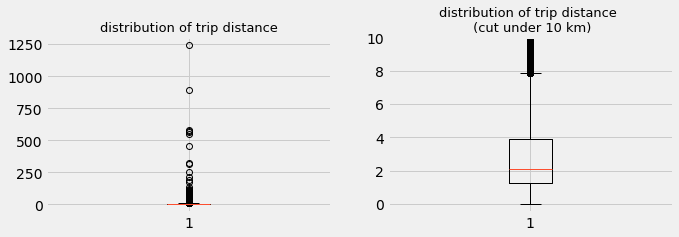

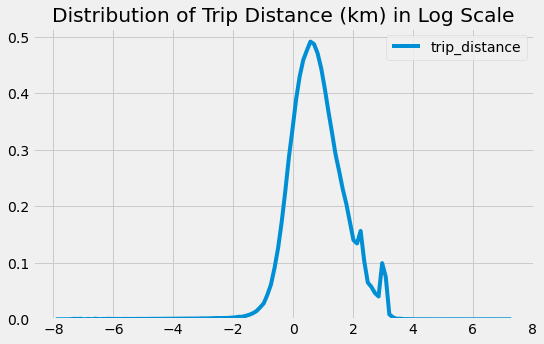

In [20]:
display(train.trip_distance.describe())

# boxplot
fig, ax = plt.subplots(1, 2, figsize=(10, 3))

ax[0].boxplot(train.trip_distance)
ax[0].set_title('distribution of trip distance', size=13)

ax[1].boxplot(train.trip_distance)
ax[1].set_title('distribution of trip distance \n (cut under 10 km)', size=13)
ax[1].set_ylim(-0.5, 10)
plt.show()


# kdeplot
plt.figure(figsize=(8, 5))
sns.kdeplot(np.log(train[train.trip_distance!=0].trip_distance))
plt.title('Distribution of Trip Distance (km) in Log Scale')
plt.show()

#### 7) Trip Distance vs Trip Duration

/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<function matplotlib.pyplot.show(*args, **kw)>

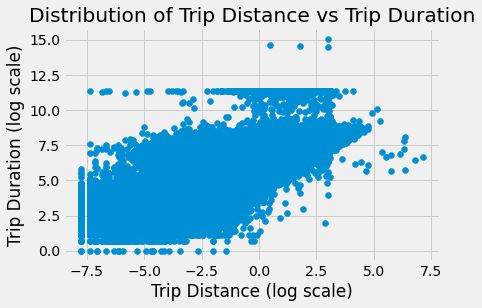

In [21]:
plt.scatter(np.log(train.trip_distance), np.log(train.trip_duration))
plt.title('Distribution of Trip Distance vs Trip Duration')
plt.xlabel('Trip Distance (log scale)')
plt.ylabel('Trip Duration (log scale)')
plt.show